## Hueristic to improve preferred path for ancestor node

In [224]:
# libraries
from ete3 import Tree
from pysam import FastaFile
from scipy.spatial.distance import hamming
import re
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [245]:
# class - to load tree, load sequences, neighbours, pogs, hamming distance, overall score for a given tree.

class PhyloTree:
    
    def __init__(self,nwk_file_path,ancestor_fasta_file,json_pogs_file):
        ''' initialise the PhyloTree Class '''
        tree_file = open(nwk_file_path,"r")
        my_tree = tree_file.read() + ";"
        self.tree = Tree(my_tree, format=1)
        self.total_indel_parsi_score = 0
        self.patience = 3
        self.all_ancestor_nodes = []
        self.all_ancestor_pogs_path = []
        self.ancestor_fasta_file = ancestor_fasta_file
        self.json_pogs_file = json_pogs_file
        self.folder_to_save_numpy_arrays = '/'.join(self.json_pogs_file.split('/')[0:-1]) + '/'
               
        
    def hamming_distance(self,str1,str2):
        ''' indel hamming distance between 2 sequences '''
        #str1 =  re.sub('[a-zA-Z]', 'a', str1)
        #str2 =  re.sub('[a-zA-Z]', 'a', str2)
        return hamming(list(str1), list(str2)) * len(str1)
        
    def load_attributes(self):
        ''' load node attributes - sequences, neighbours, hamming distance '''
        sequences_info = FastaFile(self.ancestor_fasta_file)
        
        for n in self.tree.traverse():
            node_avg_distance = 0
            ancestor_nodes_info = {}
            neighbour_list = []
            neighbour_sequence_list = []
            neighbour_dist_list = [] 
                
            if n.is_leaf() == False:    
                # add node sequence on the tree
                #n.add_features(sequence = sequences_info.fetch(n.name))
                current_node_sequence = sequences_info.fetch(n.name)
                
                for c in n.children:
                    child_sequence = sequences_info.fetch(c.name)
                    neighbour_list.append(c.name)
                    neighbour_sequence_list.append(child_sequence)
                    neighbour_dist_list.append(self.hamming_distance(current_node_sequence,child_sequence))
                    
                if n.is_root() == False:
                    parent_sequence = sequences_info.fetch(n.up.name)
                    neighbour_list.append(n.up.name)
                    neighbour_sequence_list.append(parent_sequence)
                    neighbour_dist_list.append(self.hamming_distance(current_node_sequence,parent_sequence))
                    
            
                node_avg_distance = sum(neighbour_dist_list) / len(neighbour_dist_list) 
                
                # add neighbor sequences on the tree
                #n.add_features(neighbour_sequence = neighbour_sequence_list)
                
            
            sequence_simple =  re.sub('[a-zA-Z]', 'a', sequences_info.fetch(n.name))
            self.total_indel_parsi_score += node_avg_distance # total tree score
            ancestor_nodes_info['name'] = n.name
            ancestor_nodes_info['sequence'] = sequence_simple
            ancestor_nodes_info['node_neighbors'] = neighbour_list
            ancestor_nodes_info['avg_indel_distance'] = node_avg_distance
            ancestor_nodes_info['node_neighbors_distance'] = neighbour_dist_list
            self.all_ancestor_nodes.append(ancestor_nodes_info)
        
        #print(self.all_ancestor_nodes)
        
                
    def count_path(self,a):
        ''' count the number of paths in a graph '''
        a = a + a.T    #add up the transpose
        a = np.clip(a,0,1)
        a = np.triu(a) #only the upper triangle

        nodes = a.shape[0]
        dp = [0] * nodes
        dp[nodes - 1]= 1 #last node

        for i in range(nodes - 1, -1, -1):
            neighbour_nodes = np.where (a[i] == 1)[0]
            for j in neighbour_nodes:
                dp[i] = dp[i] + dp[j]

        return(dp[0])
        
    
    def paths_in_pogs_cnt(self):
        ''' total paths in the pogs for ancestor nodes '''
        ''' save pogs as numpy array '''
        
        total_sequences_list = []
        all_exp_results = []
        
        # read the json file
        with open(self.json_pogs_file, 'r') as j:
            pog_all_data = json.loads(j.read())

            # read all ancestors
            for node_type in ['Ancestors','Extants']:
                for pog_data in pog_all_data[node_type]:
                    
                    pog_path_dict = {}
                    
                    if node_type == 'Ancestors':
                        node_name = 'N' + pog_data['Name']
                    else:
                        node_name = pog_data['Name']
                    
                    pog_path_dict['name'] = node_name

                    # read that node's data
                    nodes = pog_data['Size'] + 2

                    # create numpy zero matrix
                    mat = np.zeros(shape=(nodes,nodes))

                    # Edges from special Start node to the start nodes
                    for s in pog_data['Starts']:
                        mat[0,s + 1] = 1

                    # Edges from last node to the special End node
                    for e in pog_data['Ends']:
                        mat[e + 1,nodes-1] = 1

                    # create the adjency matrix for all nodes except from special node start
                    for ind,node in enumerate(pog_data['Indices']):
                        row_mat = node
                        row_col = pog_data['Adjacent'][ind]

                        for rc in row_col:
                            mat[row_mat + 1,rc + 1] = 1
                        

                    # count the number of viable paths from the POG
                    total_sequences = self.count_path(mat)

                    pog_path_dict['total_paths'] = total_sequences

                    self.all_ancestor_pogs_path.append(pog_path_dict)

                    # save pogs as numpy array ( needed later for markov chain hueristic)

                    # convert bidirectional mat into unidirectional
                    mat = mat + mat.T     #add up the transpose
                    mat = np.clip(mat,0,1)
                    mat = np.triu(mat)   #only the upper triangle

                    # save numpy array in file
                    mat_file_name = self.folder_to_save_numpy_arrays +  node_name + '.npy'
                    np.save(mat_file_name,mat)
                
    
    def create_mc_model(self,node_to_improve,neighbor_list):
        ''' Markov chain model to find preferred path for a ancestor node.
            Each position in the sequence is a state in the markov chain model.'''
        
        #pseudocount    = 0.0001
        total_states   = np.load(self.folder_to_save_numpy_arrays + neighbor_list[0] + '.npy').shape[0]    
        mc_model       = np.full((total_states, total_states),0)   
        
        # sum up the neighbor pog array
        for n in neighbor_list:
            m = np.load(self.folder_to_save_numpy_arrays + n + '.npy')
            mc_model = np.add(mc_model,m)
            
        # project the neighbour markov chain into the current node
        # if the path does not exists in the current node, change the value to 0
        current_node_np = np.load(self.folder_to_save_numpy_arrays + node_to_improve + '.npy')
        
        # node not present will be wiped out
        mc_model = mc_model * current_node_np
        
        # add the current node and neighbour arrays to create a markov chain on the current node
        mc_model = np.add(mc_model,current_node_np)
        
        # add pseudocounts for 0 entries
        #mc_model[mc_model == 0] = pseudocount
        
        # convert into probabilities row wise
        #mc_model = np.round(mc_model/mc_model.sum(axis=1)[:,None] ,5)
        return mc_model
        
    
    
    def mc_inference(self,mc_model):
        ''' markov chain inference to find the most probable path '''
        total_nodes = mc_model.shape[0] # total nodes to traverse
        pf    = [0] * total_nodes       # preferred path
        pf[0] = 1                       # starting node is always traversed

        i= 0
        while(i < total_nodes-1):       # till we reach the end of the nodes
            tr_ind = np.where(mc_model[i] == np.amax(mc_model[i]))[0][0] # 1st element if more than 1 returned
            pf[int(tr_ind)] = 1
            i = tr_ind
            
        pf = pf [1:-1] # return path except for the first and last path
        return pf

    
    def calculate_score(self,mc_output,node_to_improve,neighbor_list):
        neighbour_dist_list = []
        score = -1         # default score
        no_improvement = 1 # default flag
        
        # replace 1 by a and 0 by - for hamming distance calculation
        mc_output_sequence = ['a' if item == 1 else '-' for item in mc_output] 
        mc_output_sequence = ''.join(mc_output_sequence)
        
        
        # node dataframe rows
        node_df_info = self.combined_df[self.combined_df['name'] == node_to_improve]
        current_indel_distance = float(node_df_info['avg_indel_distance'].to_string(index=False))
        current_sequence = node_df_info['sequence'].to_string(index=False)
        
        # recalculate score w.r.t neighbors
        for n in neighbor_list:
            neighbor_sequence = self.combined_df[self.combined_df['name'] == \
                                              n]['sequence'].to_string(index=False)
            
            #print("Neighbor_Sequence",neighbor_sequence)
            neighbour_dist_list.append(self.hamming_distance(mc_output_sequence,neighbor_sequence))
        
        # avg indel distance
        avg_indel_distance = sum(neighbour_dist_list) / len(neighbour_dist_list) 
        
        
        # marked node as visited
        self.combined_df.loc[self.combined_df['name'] == node_to_improve, 'visited'] = True
        
        
        if avg_indel_distance < current_indel_distance: # recalculate neigh distance again
            
            print('NEW INDEL DISTANCE IS LESS THAN THE CURRENT INDEL DISTANCE')
            print("BEFORE AVERAGE INDEL DISTANCE::",current_indel_distance)
            print("NEW AVERAGE INDEL DISTANCE::",avg_indel_distance)
            
            print("BEFORE SEQUENCE:",current_sequence)
            print("AFTER SEQUENCE:",mc_output_sequence)
            
            # update the dataframe combined_df for the node being improved
            self.combined_df.loc[self.combined_df['name'] == node_to_improve,'avg_indel_distance'] \
                                            = avg_indel_distance
            self.combined_df.loc[self.combined_df['name'] == node_to_improve,'node_neighbors_distance']\
                                            = 0
            
            
            for n in neighbor_list:
                neighbor_sequence = self.combined_df[self.combined_df['name'] == \
                                              n]['sequence'].to_string(index=False)
                
                n_neighbour_dist_list = []
                n_neighbor_list = self.combined_df[self.combined_df['name'] == \
                                              n]['node_neighbors'].tolist()[0]
                if len(n_neighbor_list) != 0:
                    for n in n_neighbor_list:
                        n_neighbor_sequence = self.combined_df[self.combined_df['name'] == \
                                                          n]['sequence'].to_string(index=False)
                        n_neighbour_dist_list.append(self.hamming_distance(neighbor_sequence,n_neighbor_sequence))

                    n_avg_indel_distance = sum(n_neighbour_dist_list) / len(n_neighbour_dist_list)
                    
                    # update the neighbor distance data
                    self.combined_df.loc[self.combined_df['name'] == n,'avg_indel_distance'] \
                                            = n_avg_indel_distance
                    self.combined_df.loc[self.combined_df['name'] == n,'node_neighbors_distance']\
                                            = 0
        
            # new score
            score = self.combined_df['avg_indel_distance'].sum()
            no_improvement = 0
            
        return score,no_improvement
        
    
    def markov_chain_neighbor(self,node_to_improve,neighbor_list):
        ''' markov chain method to find preferred path '''
        
        # create model
        mc_model  = self.create_mc_model(node_to_improve,neighbor_list)
        #print("mc_model",mc_model)
        # perform inference
        mc_output = self.mc_inference(mc_model)
        #print("mc_output",mc_output)
        # evaluate score
        new_score,no_improvement = self.calculate_score(mc_output,node_to_improve,neighbor_list)
        
        return no_improvement,new_score
        
    
    def score_visual(self,score_history):
        
        iteration, score_his = zip(*score_history)
        
        # replace score -1 with the last score
        print(score_his)
        
        j = 0
        score_his = [j:= i if i else j for i in score_his]
        print(score_his)
        
        #plt.plot(*zip(*score_history))
        plt.plot(iteration,score_his)
        plt.title('SCORE IMPROVEMENT HISTORY')
        plt.xlabel('ITERATION')
        plt.ylabel('TREE - INDEL PARSIMONY SCORE')
        plt.show()
                
    def hueristic_preferred_path(self):
        ''' hueristic algorithm to improve the overall tree score by selecting alternative preferred path '''
        
        # create a combined dataframe
        self.combined_df = pd.merge(pd.DataFrame(self.all_ancestor_nodes),\
                                pd.DataFrame(self.all_ancestor_pogs_path),how='left')
        
        
        # add nodes with only 1 path in the visited nodes list
        self.combined_df['visited'] = self.combined_df['total_paths'] == 1
        
        # add rank for the nodes based on distance from neighbors
        self.combined_df['rank_distance'] = self.combined_df['avg_indel_distance'].rank()
        self.combined_df['rank_pathcnts'] = self.combined_df['total_paths'].rank()
        self.combined_df['total_rank']    = self.combined_df['rank_distance'] + self.combined_df['rank_pathcnts'] 
        
        pd.set_option('display.max_colwidth', None)
        display(self.combined_df.head(10))
        total_iterations = sum(self.combined_df['visited'] == False)
        score_not_improve = 0
        
        print("TOTAL POTENTIAL NODES FOR IMPROVEMENT::",total_iterations)
        score_track = []
        current_score = self.combined_df['avg_indel_distance'].sum()
        score_track.append((0,current_score))
        
        for i in range(1,total_iterations+1):
            print("ITERATION::",i)
            
            current_score = self.combined_df['avg_indel_distance'].sum()
            
            # pick node with max rank and which has not been visited
            df_filtered = self.combined_df[self.combined_df['visited'] == False].reset_index()
            max_df_row  = df_filtered.iloc[df_filtered['total_rank'].idxmax()]
            node_to_improve = max_df_row['name']
            node_neighbors = self.combined_df[self.combined_df['name'] == \
                                              node_to_improve]['node_neighbors'].tolist()[0]
            
            print("NODE SELECTED FOR IMPROVEMENT::",node_to_improve)
            print('NEIGHBOURS::',node_neighbors)
            
            # improve indel score here by choosing alternate path
            improvement_return,new_score = self.markov_chain_neighbor(node_to_improve,node_neighbors)
            score_not_improve += improvement_return
            
            
            if new_score != -1:
                print("SCORE IMPROVED FROM:{} TO {}".format(current_score,new_score))
                score_not_improve = 0 # reset counter 
            else:
                print("SCORE DID NOT IMPROVE")
            
            if score_not_improve >= self.patience:
                print("EXITING AS SCORE DID NOT IMROVE FOR LAST {} ITERATIONS".format(self.patience))
                break
            
            score_track.append((i,new_score))
        
        return score_track
        #self.score_visual(score_track)
        #isplay(self.combined_df.head(10))
                
            

In [246]:
# input files for the algorithm

# ## sample tree
# nwk_file_path       = '/Users/sanjanatule/Documents/uq/Projects/PreferredPath/data/sample_tree/grasp_ancestors.nwk'
# ancestor_fasta_file = "/Users/sanjanatule/Documents/uq/Projects/PreferredPath/data/sample_tree/grasp_ancestors.fa"
# pogs_file           = '/Users/sanjanatule/Documents/uq/Projects/PreferredPath/data/sample_tree/pogs.json'

# ## CYP2U
# nwk_file_path       = '/Users/sanjanatule/Documents/uq/Projects/PreferredPath/data/CYP2U_165/grasp_ancestors.nwk'
# ancestor_fasta_file = "/Users/sanjanatule/Documents/uq/Projects/PreferredPath/data/CYP2U_165/grasp_ancestors.fa"
# pogs_file           = '/Users/sanjanatule/Documents/uq/Projects/PreferredPath/data/CYP2U_165/pogs.json'

### another sample tree
nwk_file_path       = '/Users/sanjanatule/Documents/uq/Projects/PreferredPath/data/grasp_ancestors.nwk'
ancestor_fasta_file = "/Users/sanjanatule/Documents/uq/Projects/PreferredPath/data/grasp_ancestors.fa"
pogs_file           = '/Users/sanjanatule/Documents/uq/Projects/PreferredPath/data/pogs.json'

# hueristic steps
asrtree = PhyloTree(nwk_file_path,ancestor_fasta_file,pogs_file)
asrtree.load_attributes ()
asrtree.paths_in_pogs_cnt()
score_history = asrtree.hueristic_preferred_path()


,name,sequence,node_neighbors,avg_indel_distance,node_neighbors_distance,total_paths,visited,rank_distance,rank_pathcnts,total_rank
0,N0,aaaa-aaa--aaa-a----,"[N1, N24]",2.000000,"[1.0, 3.0]",3,False,98.0,97.5,195.5
1,N1,aaaa-aaa--a-a-a----,"[N2, N21, N0]",1.666667,"[1.0, 3.0, 1.0]",3,False,96.0,97.5,193.5
2,N24,aaaa-aaa--aaa-a----,"[N25, N43, N0]",1.333333,"[1.0, 0.0, 3.0]",1,True,93.0,48.5,141.5
3,N2,aaaa-aaa----a-a----,"[N3, N19, N1]",0.666667,"[0.0, 1.0, 1.0]",1,True,81.5,48.5,130.0
4,N21,aaaa-aaa--a-a-a----,"[A9, N22, N1]",1.666667,"[1.0, 1.0, 3.0]",1,True,96.0,48.5,144.5
5,N25,aaaa-aaa--aaa-a----,"[N26, N37, N24]",1.666667,"[4.0, 0.0, 1.0]",1,True,96.0,48.5,144.5
6,N43,aaaa-aaa--aaa-a----,"[N44, N47, N24]",1.000000,"[3.0, 0.0, 0.0]",1,True,89.0,48.5,137.5
7,N3,aaaa-aaa----a-a----,"[N4, N17, N2]",0.000000,"[0.0, 0.0, 0.0]",1,True,34.5,48.5,83.0
8,N19,aaaa-aaa----a-a----,"[N20, A23, N2]",0.666667,"[0.0, 1.0, 1.0]",1,True,81.5,48.5,130.0
9,A9,a-aa-aaa--a-a-a----,[],0.000000,[],1,True,34.5,48.5,83.0


TOTAL POTENTIAL NODES FOR IMPROVEMENT:: 3
ITERATION:: 1
NODE SELECTED FOR IMPROVEMENT:: N26
NEIGHBOURS:: ['N27', 'N34', 'N25']
NEW INDEL DISTANCE IS LESS THAN THE CURRENT INDEL DISTANCE
BEFORE AVERAGE INDEL DISTANCE:: 2.333333
NEW AVERAGE INDEL DISTANCE:: 2.0
BEFORE SEQUENCE: aaa----a-aaaa-a----
AFTER SEQUENCE: aaaa-aaa-aaaa-a----
SCORE IMPROVED FROM:27.66666666666666 TO 25.333333333333332
ITERATION:: 2
NODE SELECTED FOR IMPROVEMENT:: N0
NEIGHBOURS:: ['N1', 'N24']
NEW INDEL DISTANCE IS LESS THAN THE CURRENT INDEL DISTANCE
BEFORE AVERAGE INDEL DISTANCE:: 2.0
NEW AVERAGE INDEL DISTANCE:: 0.5
BEFORE SEQUENCE: aaaa-aaa--aaa-a----
AFTER SEQUENCE: aaaa-aaa--aaa-a----
SCORE IMPROVED FROM:25.333333333333332 TO 23.333333333333332
ITERATION:: 3
NODE SELECTED FOR IMPROVEMENT:: N1
NEIGHBOURS:: ['N2', 'N21', 'N0']
NEW INDEL DISTANCE IS LESS THAN THE CURRENT INDEL DISTANCE
BEFORE AVERAGE INDEL DISTANCE:: 1.666667
NEW AVERAGE INDEL DISTANCE:: 0.6666666666666666
BEFORE SEQUENCE: aaaa-aaa--a-a-a----
AF

(27.66666666666666, 25.333333333333332, 23.333333333333332, 21.166666666666664)
[27.66666666666666, 25.333333333333332, 23.333333333333332, 21.166666666666664]


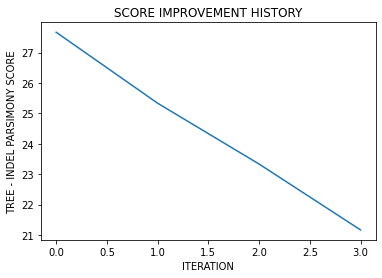

In [247]:
asrtree.score_visual(score_history)